In [8]:
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent = 4)

In [9]:
data = pd.read_csv("bases/breast.csv")
data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = data.drop(['id', 'Unnamed: 32'], axis = 1)

X = df.drop(columns='diagnosis', axis=1).values
y = df['diagnosis'].values

std = StandardScaler()
X = std.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

clss = SVC()

kfold = StratifiedKFold(n_splits= 10, random_state= 0, shuffle=True)
cv_results = cross_val_score(clss, X_train, y_train, cv=kfold)

print("SVM simples Accuracy (treino): ", cv_results.mean())

SVM simples Accuracy (treino):  0.9774358974358973


In [12]:
from sklearn.metrics import accuracy_score

clss.fit(X_train, y_train)
y_pred = clss.predict(X_test)
print("Accuracy (Teste): ", accuracy_score(y_test, y_pred))

Accuracy:  0.9766081871345029


In [ ]:
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import balanced_accuracy, precision, recall, f1
from sklearn.metrics import accuracy_score

minutos = 30

automl = AutoSklearnClassifier(
    include = {
        "classifier": ["random_forest", "extra_trees", "mlp", "gradient_boosting"]
    },
    time_left_for_this_task= minutos*60,
    per_run_time_limit= 30,
    scoring_functions= [balanced_accuracy, precision, recall, f1],
    ensemble_class= 'default',
    ensemble_nbest = 25,
    n_jobs = 4
)

automl.fit(X_train, y_train, X_test, y_test, dataset_name= 'Breast Cancer Winsconsin')

In [14]:
def get_metric_result(cv_results):
    results = pd.DataFrame.from_dict(cv_results)
    results = results[results["status"] == "Success"]
    cols = ["rank_test_scores", "param_classifier:__choice__", "mean_test_score"]
    cols.extend([key for key in cv_results.keys() if key.startswith("metric_")])
    return results[cols]

In [15]:
y_pred = automl.predict(X_test)

print("AutoML Accuracy: ", accuracy_score(y_test, y_pred))
print("#" * 80)
print("Metric results")
print(get_metric_result(automl.cv_results_).to_string(index=False))

AutoML Accuracy:  0.9824561403508771
################################################################################
Metric results
 rank_test_scores param_classifier:__choice__  mean_test_score  metric_balanced_accuracy  metric_precision  metric_recall  metric_f1
              211               random_forest         0.954545                  0.938776          1.000000       0.877551   0.934783
                6                         mlp         0.977273                  0.973568          0.979167       0.959184   0.969072
              211               random_forest         0.954545                  0.938776          1.000000       0.877551   0.934783
              211                         mlp         0.954545                  0.959675          0.905660       0.979592   0.941176
               47                         mlp         0.969697                  0.963364          0.978723       0.938776   0.958333
              147                 extra_trees         0.962121       

Ensemble final

In [16]:
pp.pprint(automl.show_models())

{   3: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f3fe09edcf0>,
           'cost': 0.022727272727272707,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f400dee5300>,
           'ensemble_weight': 0.14,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f400de46a40>,
           'model_id': 3,
           'rank': 1,
           'sklearn_classifier': MLPClassifier(activation='tanh', alpha=0.0001363185819149026, beta_1=0.999,
              beta_2=0.9, early_stopping=True,
              hidden_layer_sizes=(115, 115, 115),
              learning_rate_init=0.00018009776276177523, max_iter=64,
              n_iter_no_change=32, random_state=1, verbose=0, warm_start=True)},
    209: {   'balancing': Balancing(random_state=1, strategy='weighting')

In [17]:
models = automl.show_models()
best_model = list(models.keys())[0]

sklearn_classifier = models[best_model]["sklearn_classifier"]

print(sklearn_classifier)

print('\n', automl.sprint_statistics())

MLPClassifier(activation='tanh', alpha=0.0001363185819149026, beta_1=0.999,
              beta_2=0.9, early_stopping=True,
              hidden_layer_sizes=(115, 115, 115),
              learning_rate_init=0.00018009776276177523, max_iter=64,
              n_iter_no_change=32, random_state=1, verbose=0, warm_start=True)

 auto-sklearn results:
  Dataset name: Breast Cancer Winsconsin
  Metric: accuracy
  Best validation score: 0.984848
  Number of target algorithm runs: 612
  Number of successful target algorithm runs: 556
  Number of crashed target algorithm runs: 28
  Number of target algorithms that exceeded the time limit: 28
  Number of target algorithms that exceeded the memory limit: 0



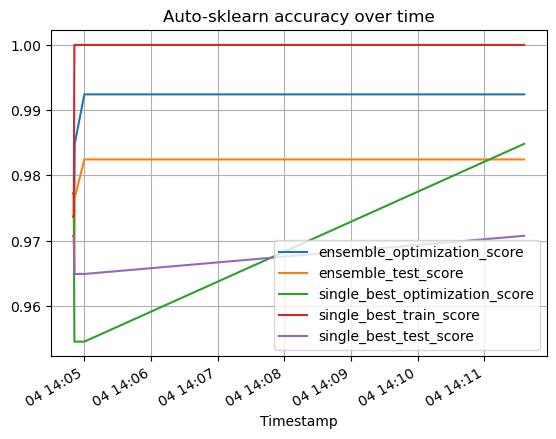

In [21]:
import matplotlib.pyplot as plt

poT = automl.performance_over_time_
poT.plot(
    x="Timestamp",
    kind="line",
    legend=True,
    title="Auto-sklearn accuracy over time",
    grid=True,
)
plt.show()

In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier

mlp = HistGradientBoostingClassifier(early_stopping=True,
                               l2_regularization=0.3843709098149898,
                               learning_rate=0.5542277381312194, loss='log_loss',
                               max_iter=64, max_leaf_nodes=5,
                               min_samples_leaf=68, n_iter_no_change=19,
                               random_state=1,
                               validation_fraction=0.03240373792923136,
                               warm_start=True)

mlp.fit(X_train,y_train)

print(mlp.score(X_test, y_test))

0.9707602339181286


In [24]:
import arff, numpy as np, pandas as pd

bases = ['1year.arff', '2year.arff', '3year.arff', '4year.arff', '5year.arff']

dfs =[]

for base in bases:
    bank = arff.load(open('bases/data/'+base, 'r'))
    data = np.array(bank['data'])
    dfs.append(pd.DataFrame(data))

i=1
for df in dfs:
    df[65] = i
    i+=1

df_bank = pd.concat(dfs)
features = df_bank.columns.values   

df_bank.shape

(43405, 66)

In [25]:
dfs[4]

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0.088238,0.55472,0.01134,1.0205,-66.52,0.34204,0.10949,0.57752,1.0881,0.32036,...,0.27543,0.91905,0.002024,7.2711,4.7343,142.76,2.5568,3.2597,0,5
1,-0.006202,0.48465,0.23298,1.5998,6.1825,0.0,-0.006202,1.0634,1.2757,0.51535,...,-0.012035,1.0047,0.15222,6.0911,3.2749,111.14,3.2841,3.37,0,5
2,0.13024,0.22142,0.57751,3.6082,120.04,0.18764,0.16212,3.059,1.1415,0.67731,...,0.19229,0.87604,0.0,8.7934,2.987,71.531,5.1027,5.6188,0,5
3,-0.089951,0.887,0.26927,1.5222,-55.992,-0.073957,-0.089951,0.1274,1.2754,0.113,...,-0.79602,0.59074,2.8787,7.6524,3.3302,147.56,2.4735,5.9299,0,5
4,0.048179,0.55041,0.10765,1.2437,-22.959,0.0,0.05928,0.81682,1.515,0.44959,...,0.10716,0.77048,0.13938,10.118,4.095,106.43,3.4294,3.3622,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5905,0.012898,0.70621,0.038857,1.1722,-18.907,0.0,0.013981,0.416,1.6768,0.29379,...,0.043904,1.0122,1.2594,13.472,12.432,49.117,7.4313,2.2799,1,5
5906,-0.57805,0.96702,-0.80085,0.16576,-67.365,-0.57805,-0.57805,-0.40334,0.93979,-0.39004,...,1.482,1.0641,-0.018084,110.72,44.759,81.22,4.494,5.1305,1,5
5907,-0.17905,1.2553,-0.27599,0.74554,-120.44,-0.17905,-0.15493,-0.26018,1.1749,-0.32659,...,0.54824,0.85112,-0.52243,9.8526,3.4892,207.87,1.7559,9.9527,1,5
5908,-0.10886,0.74394,0.015449,1.0878,-17.003,-0.10886,-0.10918,0.12531,0.84516,0.093224,...,-1.1677,1.1832,6.0924,13.886,6.0769,83.122,4.3911,0.95575,1,5


In [34]:
import pandas as pd, numpy as np
from sklearn.impute import SimpleImputer

# Criando uma instância de SimpleImputer com estratégia da média
imputer = SimpleImputer(strategy='mean')

df_bank = df_bank.astype(float)
df_bank = pd.DataFrame(imputer.fit_transform(df_bank), columns=features)

df_bank

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0.200550,0.37951,0.396410,2.04720,32.3510,0.38825,0.249760,1.33050,1.13890,0.504940,...,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.42770,0.0,1.0
1,0.209120,0.49988,0.472250,1.94470,14.7860,0.00000,0.258340,0.99601,1.69960,0.497880,...,0.420020,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.98700,0.0,1.0
2,0.248660,0.69592,0.267130,1.55480,-1.1523,0.00000,0.309060,0.43695,1.30900,0.304080,...,0.817740,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.20780,0.0,1.0
3,0.081483,0.30734,0.458790,2.49280,51.9520,0.14988,0.092704,1.86610,1.05710,0.573530,...,0.142070,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.54970,0.0,1.0
4,0.187320,0.61323,0.229600,1.40630,-7.3128,0.18732,0.187320,0.63070,1.15590,0.386770,...,0.484310,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.89800,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43400,0.012898,0.70621,0.038857,1.17220,-18.9070,0.00000,0.013981,0.41600,1.67680,0.293790,...,0.043904,1.01220,1.259400,13.4720,12.4320,49.117,7.4313,2.27990,1.0,5.0
43401,-0.578050,0.96702,-0.800850,0.16576,-67.3650,-0.57805,-0.578050,-0.40334,0.93979,-0.390040,...,1.482000,1.06410,-0.018084,110.7200,44.7590,81.220,4.4940,5.13050,1.0,5.0
43402,-0.179050,1.25530,-0.275990,0.74554,-120.4400,-0.17905,-0.154930,-0.26018,1.17490,-0.326590,...,0.548240,0.85112,-0.522430,9.8526,3.4892,207.870,1.7559,9.95270,1.0,5.0
43403,-0.108860,0.74394,0.015449,1.08780,-17.0030,-0.10886,-0.109180,0.12531,0.84516,0.093224,...,-1.167700,1.18320,6.092400,13.8860,6.0769,83.122,4.3911,0.95575,1.0,5.0


In [32]:
df_bank.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
61    float64
62    float64
63    float64
64    float64
65    float64
Length: 66, dtype: object

In [35]:
df_bank.isna().sum()

0     0
1     0
2     0
3     0
4     0
     ..
61    0
62    0
63    0
64    0
65    0
Length: 66, dtype: int64

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df_bank.drop(columns=64, axis=1).values
y = df_bank[64].values

std = StandardScaler()
X = std.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [39]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

clss = SVC()

kfold = StratifiedKFold(n_splits= 10, random_state= 0, shuffle=True)
cv_results = cross_val_score(clss, X_train, y_train, cv=kfold)

print("SVM simples Accuracy (treino): ", cv_results.mean())

SVM simples Accuracy (treino):  0.952012644053896


In [40]:
from sklearn.metrics import accuracy_score

clss.fit(X_train, y_train)
y_pred = clss.predict(X_test)
print("Accuracy (Teste): ", accuracy_score(y_test, y_pred))

Accuracy (Teste):  0.9514667485793273


In [1]:
import pandas as pd

park_data = pd.read_csv('bases/parkinsons.data', header=None)

park_data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
1,phon_R01_S01_1,119.99200,157.30200,74.99700,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.03300,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
2,phon_R01_S01_2,122.40000,148.65000,113.81900,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.08500,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
3,phon_R01_S01_3,116.68200,131.11100,111.55500,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.65100,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
4,phon_R01_S01_4,116.67600,137.87100,111.36600,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.64400,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,phon_R01_S50_2,174.18800,230.97800,94.26100,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.51700,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
192,phon_R01_S50_3,209.51600,253.01700,89.48800,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.14700,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
193,phon_R01_S50_4,174.68800,240.00500,74.28700,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.88300,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
194,phon_R01_S50_5,198.76400,396.96100,74.90400,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.02000,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [2]:
feature_names = park_data.iloc[0]
feature_names.pop(0)
features = park_data.columns.values

df = park_data.drop(park_data.index[0])
df = df.drop(0, axis=1)
df = df.astype(float)

df

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1.0,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1.0,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1.0,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1.0,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1.0,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,...,0.07008,0.02764,19.517,0.0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
192,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.04812,0.01810,19.147,0.0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
193,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,...,0.03804,0.10715,17.883,0.0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
194,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,...,0.03794,0.07223,19.020,0.0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [1]:
feature_names

NameError: name 'feature_names' is not defined

In [4]:
df[17].value_counts()

1.0    147
0.0     48
Name: 17, dtype: int64

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df.drop(columns=17, axis=1).values
y = df[17].values

std = StandardScaler()
X = std.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

sm = SMOTE()
X_train,y_train = sm.fit_resample(X_train,y_train)


In [6]:
import numpy as np

value_counts = np.unique(y_train, return_counts=True)

print(value_counts)

(array([0., 1.]), array([101, 101]))


In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

clss = SVC(kernel='linear', probability=True)

kfold = StratifiedKFold(n_splits= 10, random_state= 0, shuffle=True)
cv_results = cross_val_score(clss, X_train, y_train, cv=kfold)

print("SVM simples Accuracy (treino): ", cv_results.mean())

SVM simples Accuracy (treino):  0.8316666666666667


Accuracy (Teste):  0.7966101694915254


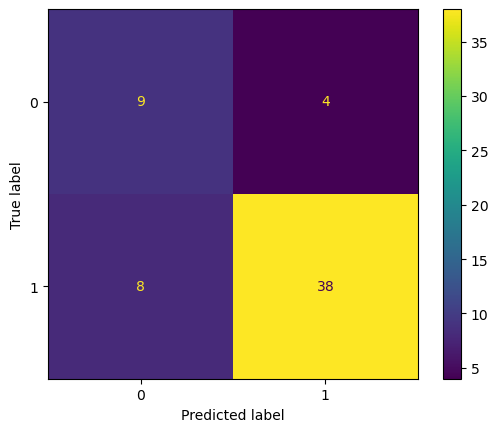

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

clss.fit(X_train, y_train)
y_pred = clss.predict(X_test)
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))

print("Accuracy (Teste): ", accuracy_score(y_test, y_pred))
cm.plot()

Using 195 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/195 [00:00<?, ?it/s]

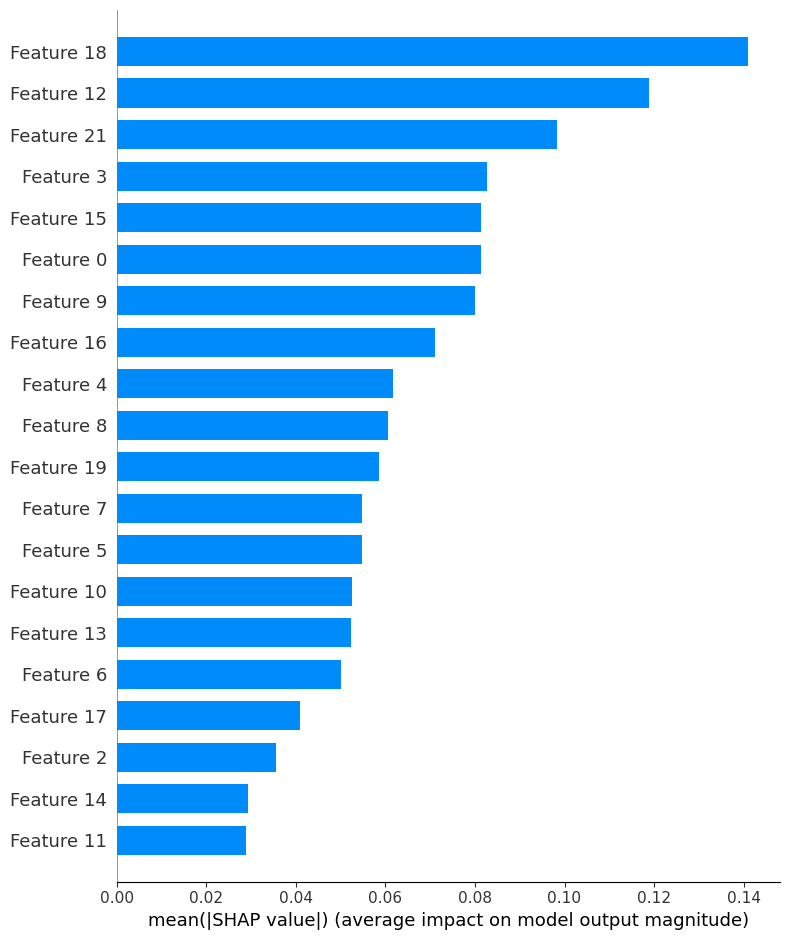

In [9]:
import shap

explainer = shap.KernelExplainer(clss.predict, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [10]:
print(features)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [11]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([features, shap_sum.tolist()]).T
importance_df.columns = ['feature', 'importance']
importance_df = importance_df.sort_values('importance', ascending=False)

print(importance_df)

    feature  importance
18     18.0    0.141053
12     12.0    0.118801
21     21.0    0.098256
3       3.0    0.082622
15     15.0    0.081443
0       0.0    0.081439
9       9.0    0.079909
16     16.0    0.071170
4       4.0    0.061668
8       8.0    0.060545
19     19.0    0.058669
7       7.0    0.054898
5       5.0    0.054813
10     10.0    0.052449
13     13.0    0.052300
6       6.0    0.050154
17     17.0    0.040997
2       2.0    0.035616
14     14.0    0.029274
11     11.0    0.028846
20     20.0    0.019473
1       1.0    0.009966
22     22.0         NaN
23     23.0         NaN


In [19]:
feature_selection = [14, 1, 20, 11, 2]

X_train_shap = np.delete(X_train, feature_selection, axis=1)
X_test_shap = np.delete(X_test, feature_selection, axis=1)

In [20]:
print(X_train_shap.shape)

(202, 17)


Accuracy (Teste):  0.8135593220338984


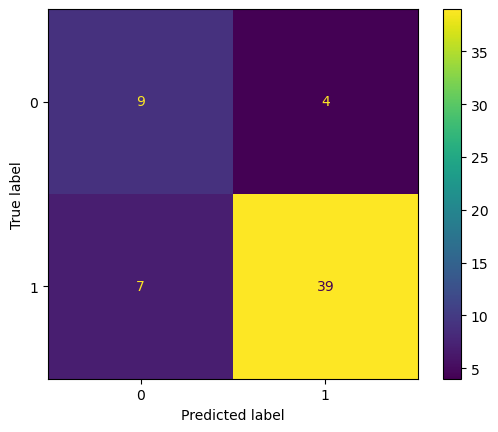

In [21]:
clss.fit(X_train_shap, y_train)
y_pred = clss.predict(X_test_shap)
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))

print("Accuracy (Teste): ", accuracy_score(y_test, y_pred))
cm.plot()